Required libraries:

In [3]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sounddevice as sd
import soundfile as sf
import warnings
import random
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

warnings.filterwarnings("ignore")

Data preprocessing:

Data from: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [5]:
train_dataset = './input/'
labels = os.listdir(train_dataset)
for label in labels:
    if not os.path.isdir(train_dataset + '/' + label):
        labels.remove(label)
labels.remove('_background_noise_')
chosen_labels = np.random.choice(labels, 5, replace=False)
print(chosen_labels)


['marvin' 'five' 'bed' 'stop' 'sheila']


In [85]:
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

Preprocessing nine...
Preprocessing eight...
Preprocessing yes...
Preprocessing wow...
Preprocessing stop...


In [86]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

In [87]:
y = to_categorical(y, num_classes=len(chosen_labels))

In [88]:
X = np.array(all_waves).reshape(-1, 8000, 1)

In [89]:
print(X.shape)
print(y.shape)

(10141, 8000, 1)
(10141, 5)


In [90]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))

X_train len 8112
X_val len 2029


In [99]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (8112, 8000, 1)
y_train shape:  (8112, 5)
X_val shape:  (2029, 8000, 1)
y_val shape:  (2029, 5)


Model

In [100]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [102]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3328 - loss: 1.4698
Epoch 1: val_accuracy improved from -inf to 0.58945, saving model to best_model.hdf5.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.3332 - loss: 1.4692 - val_accuracy: 0.5895 - val_loss: 1.0624
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6105 - loss: 0.9752
Epoch 2: val_accuracy improved from 0.58945 to 0.66042, saving model to best_model.hdf5.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6107 - loss: 0.9747 - val_accuracy: 0.6604 - val_loss: 0.9399
Epoch 3/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7693 - loss: 0.6422
Epoch 3: val_accuracy improved from 0.66042 to 0.80089, saving model to best_model.hdf5.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.7694 - loss: 0.6420 - val_accuracy: 0.8009 - val_loss: 0.6080
Epoch 4/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8204 - loss: 0.5185
Epoch 4: val_acc

Results

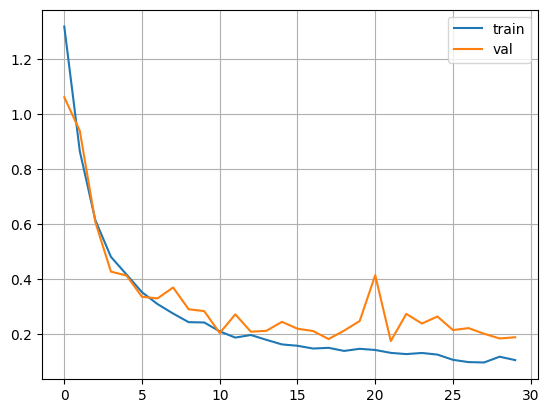

In [103]:
plt.figure()
plt.plot(range(num_epoch),history.history['loss'], label='train')
plt.plot(range(num_epoch),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

Tests

In [104]:
model = load_model('best_model.hdf5.keras')

In [105]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [106]:
sample_l = []
predict_l = []
for idx in range(len(X_val)):
    samples=X_val[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_val[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

In [107]:
print("Sample list", sample_l)
print("Predict list", predict_l)

Sample list [1, 0, 1, 2, 3, 4, 2, 0, 1, 1, 4, 0, 4, 1, 0, 1, 4, 0, 0, 1, 2, 0, 1, 2, 4, 2, 2, 4, 0, 0, 2, 2, 0, 4, 1, 2, 1, 3, 1, 4, 0, 0, 3, 2, 3, 2, 0, 2, 2, 2, 1, 0, 0, 4, 2, 0, 4, 1, 0, 2, 4, 4, 2, 3, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 0, 1, 2, 3, 4, 0, 4, 4, 0, 2, 2, 4, 2, 1, 1, 3, 3, 1, 1, 4, 3, 0, 3, 4, 2, 2, 2, 0, 1, 2, 2, 2, 3, 0, 2, 3, 3, 2, 1, 0, 0, 0, 3, 4, 3, 2, 0, 1, 1, 4, 2, 0, 4, 2, 4, 4, 1, 4, 4, 4, 0, 0, 2, 0, 0, 3, 1, 2, 2, 4, 2, 2, 1, 4, 4, 0, 2, 2, 2, 4, 4, 0, 2, 4, 3, 4, 4, 4, 4, 1, 1, 2, 3, 2, 2, 2, 2, 0, 4, 0, 3, 2, 4, 1, 3, 2, 1, 1, 3, 1, 0, 2, 4, 4, 0, 2, 4, 4, 4, 1, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 4, 0, 3, 3, 4, 2, 0, 3, 1, 1, 3, 1, 3, 2, 2, 2, 2, 3, 2, 4, 1, 1, 3, 3, 4, 0, 3, 1, 0, 4, 4, 1, 3, 4, 1, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 2, 1, 1, 4, 4, 0, 3, 4, 1, 3, 2, 3, 0, 0, 0, 0, 1, 0, 3, 4, 1, 3, 1, 0, 0, 0, 4, 2, 4, 1, 1, 2, 4, 0, 4, 3, 0, 4, 1, 4, 4, 0, 4, 2, 2, 2, 1, 0, 0, 1, 2, 0, 3, 0, 4, 0, 4, 3, 4, 2, 0, 0, 2, 1, 1, 2, 4, 4, 1, 2, 3, 0, 1, 

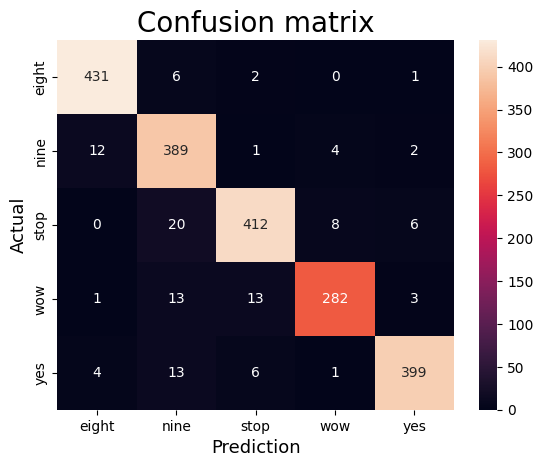

In [108]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [109]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.96      0.98      0.97       440
        nine       0.88      0.95      0.92       408
        stop       0.95      0.92      0.94       446
         wow       0.96      0.90      0.93       312
         yes       0.97      0.94      0.96       423

    accuracy                           0.94      2029
   macro avg       0.94      0.94      0.94      2029
weighted avg       0.94      0.94      0.94      2029



Transfer learning

In [274]:
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
new_labels = []
while len(new_labels) != 5:
    r_label = str(np.random.choice(labels))
    if r_label not in chosen_labels and r_label not in new_labels:
        new_labels.append(r_label)

print("New labels: ", new_labels)
print("Chosen labels: ", chosen_labels)

New labels:  ['happy', 'four', 'seven', 'bed', 'sheila']
Chosen labels:  ['eight', 'nine', 'stop', 'wow', 'yes']


In [275]:
all_waves = []
all_labels = []
for label in new_labels:
    print("Preprocessing {}...".format(label))
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

Preprocessing happy...
Preprocessing four...
Preprocessing seven...
Preprocessing bed...
Preprocessing sheila...


In [276]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

In [277]:
idxs = np.random.randint(8904, size=3000)
idxs

array([7236, 4714, 8114, ..., 6059, 7074, 4188], dtype=int32)

In [278]:
y = to_categorical(y, num_classes=len(new_labels))
y = y[idxs, :]

In [279]:
X = np.array(all_waves).reshape(-1, 8000, 1)
X = X[idxs, :]

In [280]:
print(X.shape)
print(y.shape)

(3000, 8000, 1)
(3000, 5)


In [281]:
# Data augmentation HERE
for i in range(3000):
    noise = np.random.randn(len(X[0])).reshape(-1, 1)
    X = np.vstack([X, np.add(X[i], 0.01*noise)[None, :, :]])
    y = np.vstack([y, y[i, :]])

In [282]:
print(X.shape)
print(y.shape)

(6000, 8000, 1)
(6000, 5)


In [283]:
idx = np.random.randint(3000, 6000)
samples=X[idx].ravel()
print("Audio:",classes[np.argmax(y[idx])])
ipd.Audio(samples, rate=8000)

Audio: seven


In [284]:
for i in range(3000):
    shift = 1000
    X = np.vstack([X, np.roll(X[i], shift)[None, :, :]])
    y = np.vstack([y, y[i, :]])

In [285]:
print(X.shape)
print(y.shape)

(9000, 8000, 1)
(9000, 5)


In [286]:
idx = np.random.randint(6000, 9000)
samples=X[idx].ravel()
print("Audio:",classes[np.argmax(y[idx])])
ipd.Audio(samples, rate=8000)

Audio: four


In [287]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))

X_train len 7200
X_val len 1800


In [288]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [289]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_aug.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [290]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2918 - loss: 1.5467
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to best_model_aug.hdf5.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.2920 - loss: 1.5464 - val_accuracy: 0.4200 - val_loss: 1.3363
Epoch 2/30
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4526 - loss: 1.2581
Epoch 2: val_accuracy improved from 0.42000 to 0.55056, saving model to best_model_aug.hdf5.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.4528 - loss: 1.2579 - val_accuracy: 0.5506 - val_loss: 1.0762
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5870 - loss: 1.0105
Epoch 3: val_accuracy improved from 0.55056 to 0.69611, saving model to best_model_aug.hdf5.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.5872 - loss: 1.0102 - val_accuracy: 0.6961 - val_loss: 0.8242
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6899 - loss: 0.7531
Epoc

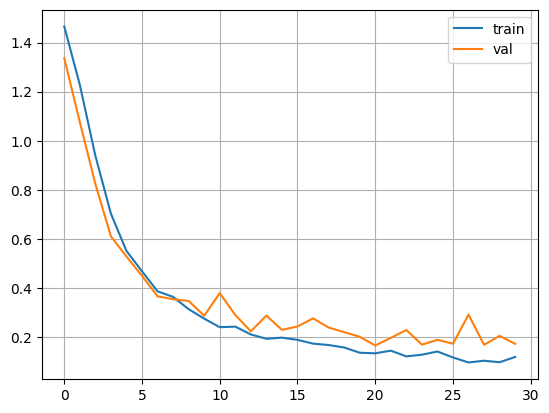

In [292]:
plt.figure()
plt.plot(range(num_epoch),history.history['loss'], label='train')
plt.plot(range(num_epoch),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [293]:
model = load_model('best_model_aug.hdf5.keras')

In [294]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [295]:
sample_l = []
predict_l = []
for idx in range(len(X_val)):
    samples=X_val[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_val[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

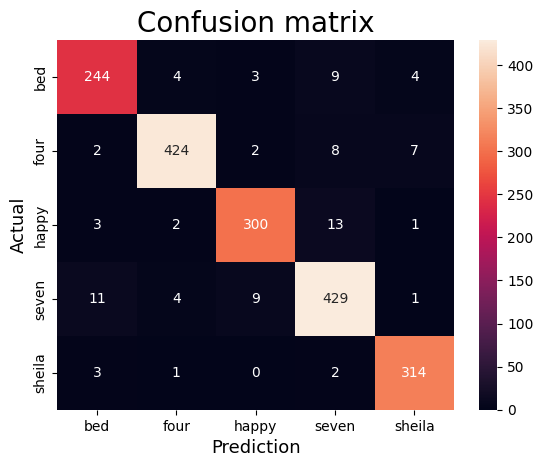

In [296]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [297]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

         bed       0.93      0.92      0.93       264
        four       0.97      0.96      0.97       443
       happy       0.96      0.94      0.95       319
       seven       0.93      0.94      0.94       454
      sheila       0.96      0.98      0.97       320

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



Check your voice sample: 

In [85]:
samplerate = 16000
duration = 1
filename = 'voice.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)


start
end


In [86]:
#reading the voice commands
samples, sample_rate = librosa.load('voice.wav', sr = 16000)
samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples,rate=8000) 

In [87]:
result = predict(samples)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
up
